# CSS Lab: Extra Topics in CSS

## Section 1: Background

Much of the data studied in other labs is digital trace data from online platforms. However, computational methods can be used to study many types of data. In this lab, you will examine records of taxi trips, compiled by the New York City [Taxi and Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Many cities compile data on city functions and make them available through APIs and open data portals.

Taxi trips vary from data studied so far because they combine space, time, and network data. In NYC geographic ___zones___ are used to classify the pick-up and drop-off location of each trip. Taxi trips form a network of interconnections between zones, with each pick-up and drop-off representing a point in space and time.

In this lab, you will combine the taxi data with US Census data to study how socioeconomic factors relate to interconnections between taxi zones.

## Section 2: Setup

In [1]:
import cartopy.io.shapereader as shpreader
from datetime import datetime
from descartes import PolygonPatch
import fiona
import math
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spstats
import shapefile
from shapely.geometry import MultiPoint, MultiPolygon, Point, shape
import sys
from tqdm import tqdm

%matplotlib inline

## Section 3: Data
### 3.1 American Community Survey Data

In [2]:
# Load raw census data
df_census_raw = pd.read_csv('census.tsv', delimiter='\t')
df_census_raw['index'] = df_census_raw.FIPS
df_census_raw = df_census_raw.set_index('index')

# Create data frame of just the data we need
df = pd.DataFrame(index=df_census_raw.index)
df['FIPS'] = df_census_raw['FIPS']
df['income'] = df_census_raw['Families: Median Family Income in the Past 12 Months (In 2016 Inflation-Adjusted Dollars)']
df['population'] = df_census_raw['Total Population.1']
df['non_hispanic_white'] = df_census_raw['Not Hispanic or Latino: White Alone']
df['non_hispanic_white_frac'] = df['non_hispanic_white'] / df['population']
df_census = df.dropna()

df_census.head()

,FIPS,income,population,non_hispanic_white,non_hispanic_white_frac
index,,,,,
36005000200,36005000200,75165.0,5251,93,0.017711
36005000400,36005000400,81163.0,5980,243,0.040635
36005001600,36005001600,36701.0,6056,142,0.023448
36005001900,36005001900,39010.0,2682,195,0.072707
36005002000,36005002000,20789.0,9131,128,0.014018


### 3.2 Taxi Trip Data

In [3]:
df_yellow = pd.read_csv('taxi/yellow_tripdata_2017-01.csv')
df_green = pd.read_csv('taxi/green_tripdata_2017-01.csv')
df_taxi = pd.concat([df_yellow, df_green])
df_taxi.head()

,DOLocationID,PULocationID,RatecodeID,VendorID,ehail_fee,extra,fare_amount,improvement_surcharge,lpep_dropoff_datetime,lpep_pickup_datetime,...,passenger_count,payment_type,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,trip_type
0,161,263,1,1,NaN,0.0,12.5,0.3,NaN,NaN,...,1,1,N,2.00,0.0,15.30,2017-01-09 11:25:45,2017-01-09 11:13:28,3.30,NaN
1,234,186,1,1,NaN,0.0,5.0,0.3,NaN,NaN,...,1,1,N,1.45,0.0,7.25,2017-01-09 11:36:01,2017-01-09 11:32:27,0.90,NaN
2,161,164,1,1,NaN,0.0,5.5,0.3,NaN,NaN,...,1,1,N,1.00,0.0,7.30,2017-01-09 11:42:05,2017-01-09 11:38:20,1.10,NaN
3,75,236,1,1,NaN,0.0,6.0,0.3,NaN,NaN,...,1,1,N,1.70,0.0,8.50,2017-01-09 11:57:36,2017-01-09 11:52:13,1.10,NaN
4,234,249,2,2,NaN,0.0,52.0,0.3,NaN,NaN,...,1,2,N,0.00,0.0,52.80,2017-01-01 00:00:00,2017-01-01 00:00:00,0.02,NaN


### 3.3 Load NYC Taxi Zones

In [4]:
# Helper functions

def log_ticks(low, high):
    lowexp = math.floor(low)
    highexp = math.ceil(high)
    ticks = []
    labels = []
    for e in range(lowexp, highexp + 1):
        for i in range(1, 10):
            v = i * 10**e
            logv = np.log10(v)
            if logv > lowexp and logv < highexp:
                ticks.append(logv)
                labels.append(v)
            if highexp - lowexp > 2:
                break
    return ticks, labels

def plot_geo_values(zones, key=None, label=None, transform=None, cmap='Blues'):
    if transform is None:
        tf = lambda x: x
        itf = lambda x: x
    elif transform == 'log':
        tf = np.log10
        itf = lambda x: np.power(10, x)
    if key is not None:
        values = [r.attributes[key] for r in zones]
        if transform == 'log':
            # Drop zeros for log transform
            values = [v for v in values if v > 0]
        count_max, count_min = tf(max(values)), tf(min(values))
        count_span = count_max - count_min
    patches = []
    cm = plt.get_cmap(cmap)
    for record in zones:
        if key is not None:
            try:
                raw_value = record.attributes[key]
                if transform == 'log' and raw_value == 0:
                    # Skip 0 values for log
                    continue
                value = tf(raw_value)
            except KeyError:
                if transform == 'log':
                    continue
                else:
                    value = 0
            color = cm((value - count_min) / count_span)
        else:
            color = "#efefef"
        patch = PolygonPatch(record._geometry, fc=color, ec='#555555', lw=0.2, alpha=1, zorder=1)
        patches.append(patch)

    mp = MultiPolygon([
        shape(record._geometry)
        for record in zones])
    minx, miny, maxx, maxy = mp.bounds
    w, h = maxx - minx, maxy - miny
    aspect = w / h

    fig = plt.figure(figsize=(8 * aspect / 0.9, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
    ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
    ax.set_aspect(1)
    ax.add_collection(PatchCollection(patches, match_original=True))
    
    if key is not None:
        # Add colorbar
        plt.subplots_adjust(right=0.9)
        cax = plt.axes([0.95, 0.1, 0.035, 0.8])
        norm = mpl.colors.Normalize(vmin=count_min, vmax=count_max)
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm,
                                        norm=norm,
                                        orientation='vertical')
        if label is not None:
            cb1.set_label(label)
        else:
            cb1.set_label(key)
        if transform == 'log':
            ticks, labels = log_ticks(count_min, count_max)
            cb1.set_ticks(ticks)
            cb1.set_ticklabels(labels)

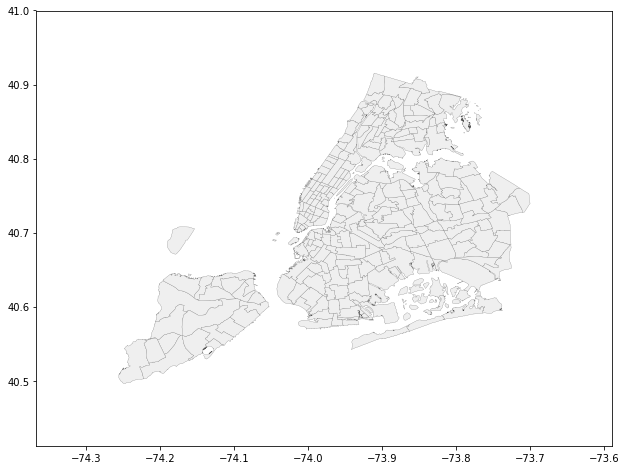

In [5]:
reader = shpreader.Reader('taxi/taxi_zones/taxi_zones-latlong.shp')
taxi_geo = list(reader.records())
plot_geo_values(taxi_geo)

### 3.4 Load Census Tracts

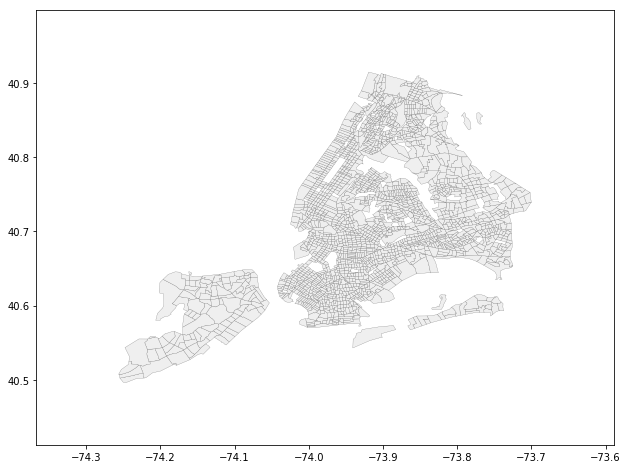

In [6]:
reader = shpreader.Reader('tracts/cb_2017_36_tract_500k.shp')
tract_geo = list(reader.records())

# Keep tracts in NYC
geoids = set(df_census['FIPS'])
tract_geo = [
    record for record in tract_geo
    if int(record.attributes['GEOID']) in geoids]

plot_geo_values(tract_geo)

## Section 4. Visualize Data
#### Count Pick-Ups and Drop-Offs

Let's start by visualizing the data. First, we use a helper function to count the number of pick-ups and drop-offs in each taxi zone.

In [7]:
# Helper functions

def annotate_records(records, data, key):
    for r in records:
        geoid = int(r.attributes['GEOID'])
        r.attributes[key] = data[geoid]

def update_counts(df, records):
    print('Updating counts')
    counts_pickup = df.groupby('PULocationID').count()['VendorID']
    counts_dropoff = df.groupby('DOLocationID').count()['VendorID']
    zone_pu_counts = {}
    zone_do_counts = {}
    for zone, count in dict(counts_pickup).items():
        zone_pu_counts[zone] = count
    for zone, count in dict(counts_dropoff).items():
        zone_do_counts[zone] = count
    for r in records:
        geoid = r.attributes['LocationID']
        r.attributes['pickups'] = zone_pu_counts.get(geoid, 0)    
        r.attributes['dropoffs'] = zone_do_counts.get(geoid, 0)    


In [8]:
update_counts(df_taxi, taxi_geo)
taxi_geo[0].attributes

Updating counts


{'LocationID': 1,
 'OBJECTID': 1,
 'Shape_Area': 0.0007823067885,
 'Shape_Leng': 0.116357453189,
 'borough': 'EWR',
 'dropoffs': 16135,
 'pickups': 709,
 'zone': 'Newark Airport'}

#### Visualize Pick-Ups
The following cell plots a map of New York taxi zones, with darker zones representing more taxi pick-ups. The number of pick-ups exhibits a heavy tail, so the colors are chosen based on the logarithm of the counts.

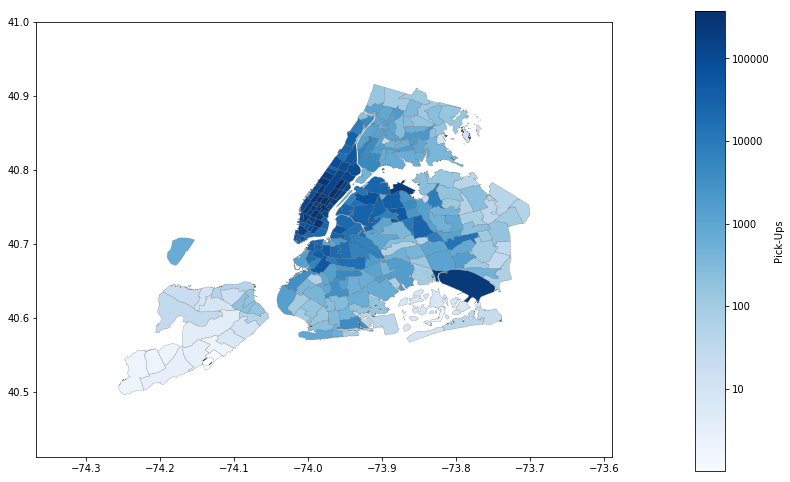

In [9]:
plot_geo_values(taxi_geo, 'pickups', 'Pick-Ups', transform='log')

#### Remove Airports
In the above visualization, the taxi zones representing airports stand out as outliers. We can remove them from the analysis and update trip counts using the following code.

/Users/elplatt/science3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Updating counts


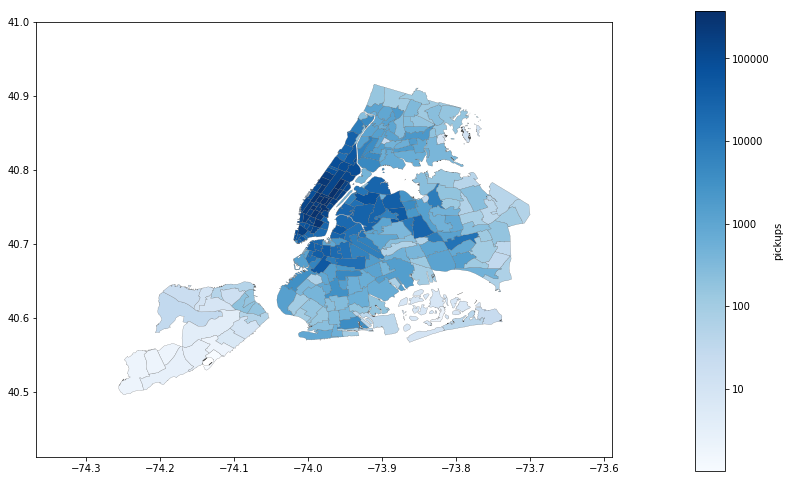

In [10]:
# Identify airport zones
airports = [r for r in taxi_geo if 'Airport' in r.attributes['zone']]
airport_zones = [r.attributes['zone'] for r in airports]

# Remove airports zones and trips
taxi_geo = [r for r in taxi_geo if 'Airport' not in r.attributes['zone']]
df_taxi = df_taxi[
    (~df_taxi['DOLocationID'].isin(airport_zones))
    & (~df_taxi['PULocationID'].isin(airport_zones))]

# Update counts and plot
update_counts(df_taxi, taxi_geo)
plot_geo_values(taxi_geo, 'pickups', transform='log')

#### Short Answer
Whether or not to include airports depends on the type of questions we want to answer. Most people travelling to and from airports do not live or work at that airport. For each of the following two examples, explain why you would or would not include trips to and from airports in an analysis:

1. Understanding wear and tear on roads.
2. Understanding relationships between residential communities.

🤔 Your answer here:

#### Visualize income
Now let's visualize household income. This data is organized into census tracts, which are typically smaller than taxi zones.

In [11]:
# Helper functions

# Get geoid->values from df for each element in geo
def get_geo_map(df, key, geo):
    result = {}
    for i, r in enumerate(geo):
        geoid = int(r.attributes['GEOID'])
        result[geoid] = df.loc[geoid, key]
    return result

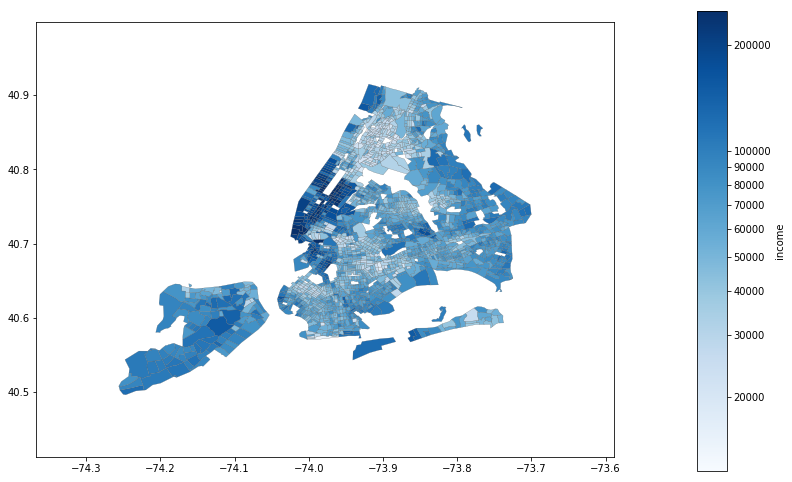

In [12]:
tract_income_map = get_geo_map(df_census, 'income', tract_geo)
annotate_records(tract_geo, tract_income_map, 'income')
plot_geo_values(tract_geo, 'income', transform='log')

#### Short Answer
Do the areas with high income tend to have a higher than average, near average, or below average number of taxi pick-ups?

What is one way income level could influence the number of taxi trips to or from a neighborhood?

🤔 Your answer here:

## Pairwise Trip Data
Rather than individual zone pick-ups, we're really interested in connections _between_ zones. In other words, we want to analyze the pairwise trip data.

#### Create data frame for pairwise data
The first step is to create a new data frame. The entries of this data frame are indexed by pairs of zones rather than single zones.

In [13]:
# Helper functions

def make_pair_df(geo):
    index = set([
        (r.attributes['LocationID'], s.attributes['LocationID'])
        for r in geo
        for s in geo
        if r.attributes['LocationID'] != s.attributes['LocationID']
    ])
    df_pairs = pd.DataFrame(index=list(index))
    return df_pairs

def plot_pairs(
    geo,
    df_pairs,
    key,
    label=None,
    bounds=None,
    threshold=0,
    transform=None,
    linewidth=0.1,
    alpha=0.3
):
    points = {}
    patches = []
    print('Finding representative points')
    sys.stdout.flush()
    for record in tqdm(geo):
        patch = PolygonPatch(record._geometry, fc='#efefef', ec='#555555', lw=0.2, alpha=1, zorder=1)
        patches.append(patch)
        record_id = record.attributes['LocationID']
        points[record_id] = record._geometry.representative_point().coords[0]

    mp = MultiPolygon([
        shape(record._geometry)
        for record in geo])
    minx, miny, maxx, maxy = mp.bounds
    w, h = maxx - minx, maxy - miny

    if bounds is None:
        xlim = (minx - 0.2 * w, maxx + 0.2 * w)
        ylim = (miny - 0.2 * h, maxy + 0.2 * h)
    else:
        xlim = (bounds[0], bounds[1])
        ylim = (bounds[2], bounds[3])
    ar = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    
    fig = plt.figure(figsize=(8 * ar, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.add_collection(PatchCollection(patches, match_original=True))
    
    if transform is None:
        tf = lambda x: x
        itf = lambda x: x
    if transform == 'log':
        tf = np.log10
        itf = lambda x: np.power(10, x)
        
    trip_max = tf(df_pairs['trips'].max())
    
    cm = plt.get_cmap('afmhot')
    sys.stdout.flush()
    print('Drawing lines')
    sys.stdout.flush()
    for a_id, b_id in tqdm(df_pairs.index):
        # Combine both directions for plot
        if a_id >= b_id:
            continue
        a_point = points[a_id]
        b_point = points[b_id]
        try:
            raw_count = (
                df_pairs['trips'][(a_id, b_id)]
                + df_pairs['trips'][(b_id, a_id)])
            try:
                if raw_count < threshold:
                    continue
            except ValueError:
                print("raw", raw_count, 't', threshold, 'a', a_id, 'b', b_id)
                raise
            count = tf(raw_count)
            f = count / trip_max
            color = "#000000"
            l = mlines.Line2D(
                [a_point[0], b_point[0]],
                [a_point[1], b_point[1]],
                color='#000000',
                linewidth=linewidth,
                alpha=f*alpha)
            ax.add_line(l)
        except RuntimeError:
            pass

In [14]:
df_pairs = make_pair_df(taxi_geo)
df_pairs.head()

""
"(252, 36)"
"(238, 115)"
"(111, 227)"
"(185, 101)"
"(5, 178)"


#### Count number of trips
Now we can count the number of trips between each pair of zones.

In [15]:
# Helper function

# Calculate number of trips
def count_trips(df_taxi, df_pairs):
    print('Counting trips')
    index = df_pairs.index
    df_count = df_taxi.groupby(['PULocationID', 'DOLocationID']).count()['VendorID']
    df_pairs['trips'] = np.zeros(len(index))
    for a_id, b_id in tqdm(df_pairs.index):
        # Sum trips in both directions
        count = df_count.get((a_id, b_id), 0)
        df_pairs.trips[(a_id, b_id)] = count

In [16]:
count_trips(df_taxi, df_pairs)
#plt.hist(df_pairs.trips, bins=30)
#plt.xlabel('Trips Between Zones')
#plt.ylabel('Number of Zone Pairs')
df_pairs.sort_values('trips', ascending=False).head()

Counting trips


100%|██████████| 65792/65792 [00:26<00:00, 2488.51it/s]


,trips
"(237, 236)",56245.0
"(236, 237)",48092.0
"(239, 238)",29125.0
"(239, 142)",27492.0
"(142, 239)",25429.0


#### Visualize Trips
The following visualization draws a line between each pair of zones, with darker lines representing more traffic.

Finding representative points


100%|██████████| 260/260 [00:00<00:00, 1066.07it/s]


Drawing lines


100%|██████████| 65792/65792 [00:17<00:00, 3664.09it/s]


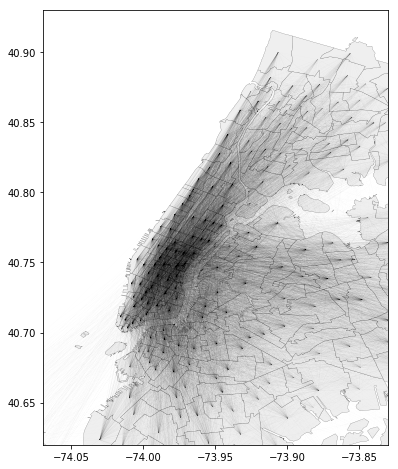

In [17]:
plot_pairs(
    taxi_geo, df_pairs, 'trips',
    label='Trips',
    bounds=(-74.07, -73.83, 40.62, 40.93),
    transform='log')

#### Adding a Threshold
The above visualization is a little difficult to interpret because there are so many lines. One way to reduce clutter is to add a threshold, only drawing lines between zones with a minimum number of trips.

Finding representative points


100%|██████████| 260/260 [00:00<00:00, 1130.10it/s]


Drawing lines


100%|██████████| 65792/65792 [00:00<00:00, 72898.92it/s]


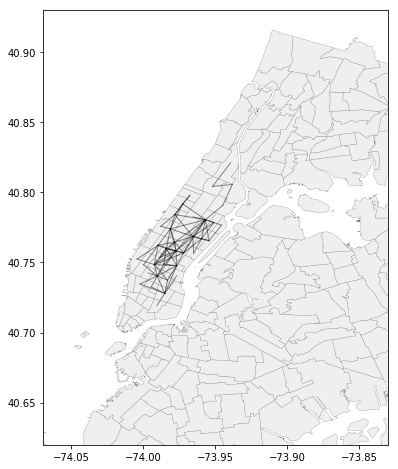

In [18]:
threshold = 20000
plot_pairs(
    taxi_geo, df_pairs, 'trips',
    label='Trips',
    bounds=(-74.07, -73.83, 40.62, 40.93),
    threshold=threshold,
    linewidth=1,
    alpha=0.5,
    transform='log')

#### Short Answer

What's the takeaway? Speculate on why?
Borough? Trip length? Hubs? 

🤔 Your answer here:

#### Calculate Mean Trip Distance

In [19]:
def get_mean_distance(df_taxi, df_pairs):
    print('Finding mean distance')
    # Calculate mean trip distance
    df_mean = df_taxi.groupby(['PULocationID', 'DOLocationID']).mean()
    df_trip = df_mean['trip_distance']
    df_pairs['trip_distance'] = np.zeros(len(df_pairs.index))
    for a_id, b_id in tqdm(df_pairs.index):
        # Get counts in each direction
        ab_count = df_pairs['trips'].get((a_id, b_id), 0)
        ba_count = df_pairs['trips'].get((b_id, a_id), 0)
        # If no trips, average distance is undefined
        if (ab_count + ba_count == 0):
            df_pairs.loc[(a_id, b_id), 'trip_distance'] = float('nan')
        # Otherwise take a weighted average of each direction
        else:
            df_pairs.loc[(a_id, b_id), 'trip_distance'] = (
               ab_count * df_trip.get((a_id, b_id), 0)
                + ba_count * df_trip.get((b_id, a_id), 0)) / (ab_count + ba_count)

In [20]:
get_mean_distance(df_taxi, df_pairs)

Finding mean distance


100%|██████████| 65792/65792 [00:34<00:00, 1912.62it/s]


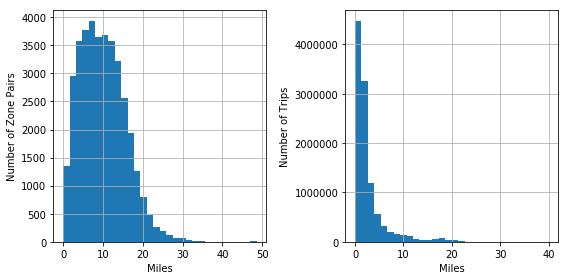

In [21]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1);
df_pairs['trip_distance'].hist(bins=30)
plt.xlabel("Miles")
plt.ylabel("Number of Zone Pairs")
plt.subplot(1, 2, 2);
plt.hist(df_taxi[df_taxi['trip_distance'] < 40]['trip_distance'], bins=30)
plt.xlabel("Miles")
plt.ylabel("Number of Trips")
plt.grid()
plt.tight_layout()

#### Compute a map from census tract values to taxi zone

In [22]:
# Helper functions

# Create a function mapping census tract vectors to taxi zone vectors
def get_tract_to_zone(taxi_geo, tract_geo):
    # Get fractions of zone overlapping each tract
    weight_zone_tract, all_zones = get_weight_zone_tract(taxi_geo, tract_geo)
    # Create a function to map census data to taxi zones
    def tract_to_zone(tract_data):
        zone_data = pd.Series(index=list(all_zones))
        for zone_id in tqdm(all_zones):
            zone_data[zone_id] = 0
            for tract_id, d in tract_data.items():
                f = weight_zone_tract[zone_id][tract_id]
                zone_data[zone_id] += f * tract_data[tract_id]
        return zone_data
    # Return function
    return tract_to_zone

# Create a function mapping census tract vectors to taxi zone vectors
def get_weight_zone_tract(taxi_geo, tract_geo):
    
    # Calculate the fraction of each zone that overlaps with a given tract
    weight_zone_tract = {}
    empty_zones = set()
    all_zones = set()
    for zone in tqdm(taxi_geo):
        zone_id = zone.attributes['LocationID']
        all_zones.add(zone_id)
        weight_tract = {}
        for tract in tract_geo:
            tract_id = int(tract.attributes['GEOID'])
            # This is a rough approximation that treats lat/long as cartesian
            f = zone._geometry.intersection(tract._geometry).area / zone._geometry.area
            weight_tract[tract_id] = f
        # Exclude taxi zones without enough data
        zone_total = sum(weight_tract.values())
        if zone_total < 0.5:
            empty_zones.add(zone_id)
        else:
            # Normalize
            for tract_id in weight_tract.keys():
                weight_tract[tract_id] /= zone_total
        weight_zone_tract[zone_id] = weight_tract
    return weight_zone_tract, all_zones


In [23]:
tract_to_zone = get_tract_to_zone(taxi_geo, tract_geo)

100%|██████████| 260/260 [00:32<00:00,  7.88it/s]


#### Taxi Zone Income

In [24]:
zone_incomes = tract_to_zone(df_census['income'])

100%|██████████| 257/257 [00:13<00:00, 18.83it/s]


100%|██████████| 260/260 [00:00<00:00, 55224.54it/s]


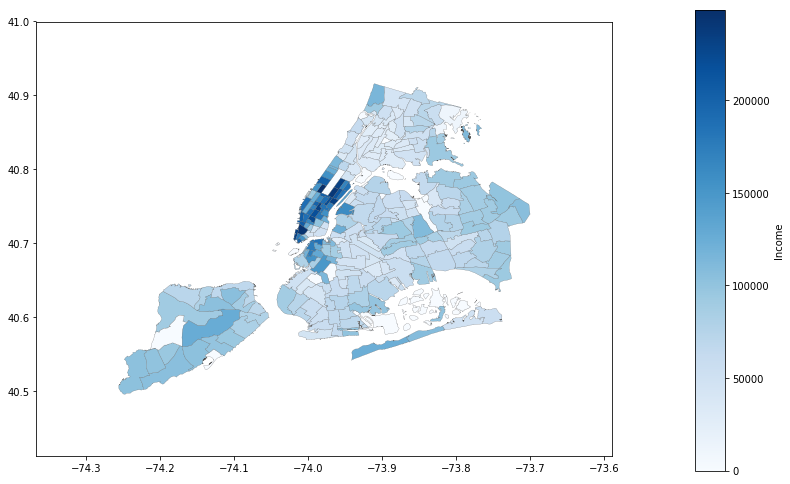

In [25]:
for zone in tqdm(taxi_geo): 
    zone_id = zone.attributes['LocationID']
    zone.attributes['income'] = zone_incomes[zone_id]
plot_geo_values(taxi_geo, 'income', label="Income")

Text(0,0.5,'Number of Zones')

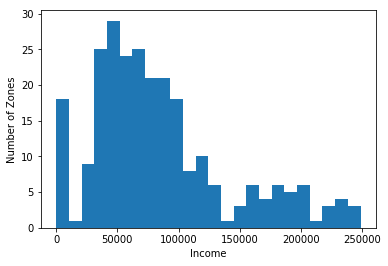

In [26]:
plt.hist(zone_incomes, bins=24)
plt.xlabel('Income')
plt.ylabel('Number of Zones')

#### Income Difference

In [27]:
# Helper functions

# Calculate trips vs income difference
def get_log_diff(df_pairs, attribute, values, min_value=0):
    print('Finding attribute difference')
    key = 'log_{}_diff'.format(attribute)
    df_pairs[key] = np.zeros(len(df_pairs.index))
    for i, j in tqdm(df_pairs.index):
        a = values[i]
        b = values[j]
        # Ignore zero case and partial zones
        if a > min_value and b > min_value:
            df_pairs.loc[(i, j), key] = np.log10(b) - np.log10(a)
        else:
            df_pairs.loc[(i, j), key] = float('nan')

def get_diff(df_pairs, attribute, values, min_value=0):
    print('Finding attribute difference')
    key = '{}_diff'.format(attribute)
    df_pairs[key] = np.zeros(len(df_pairs.index))
    for i, j in tqdm(df_pairs.index):
        a = values[i]
        b = values[j]
        if a > min_value and b > min_value:
            df_pairs.loc[(i, j), key] = b - a
        else:
            df_pairs.loc[(i, j), key] = float('nan')


In [28]:
min(df_census['income'])

12300.0

  1%|          | 450/65792 [00:00<00:14, 4497.43it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4829.70it/s]


Text(0,0.5,'Number of pairs')

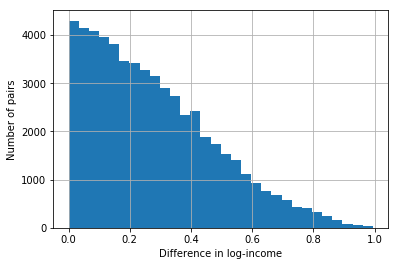

In [29]:
get_log_diff(df_pairs, 'income', zone_incomes, min_value=12300)
df_pairs['log_income_diff'].abs().hist(bins=30)
plt.xlabel('Difference in log-income')
plt.ylabel('Number of pairs')

#### Comparing income and connectivity

In [30]:
# Helper functions

def plot_binned(x, y, alpha=1, bins=30, log=None, xlabel=None, ylabel=None, title=None):
    # Remove nan
    isnan = np.isnan(x) | np.isnan(y)
    x = np.array(x)[~isnan]
    y = np.array(y)[~isnan]
    num_bins = bins
    low = min(x)
    high = max(x)
    delta = (high - low) / num_bins
    bin_x = [[] for i in range(num_bins)]
    bin_y = [[] for i in range(num_bins)]
    bin_cx = [low + delta * (i + 1/2) for i in range(num_bins)]
    for i in range(len(x)):
        try:
            b = int(math.floor((x[i] - low) / delta))
        except ValueError:
            print(x[i] == 'nan', x[i], low, delta)
            raise
        if b == num_bins:
            # Include edge case on top bin
            b -= 1
        bin_x[b].append(x[i])
        bin_y[b].append(y[i])
    means = np.array([np.mean(by) for by in bin_y])
    std = np.array([np.std(by) for by in bin_y])
    count = np.sqrt(np.array([len(by) for by in bin_y]))
    se = std / count
    low95 = means - 2 * se
    high95 = means + 2 * se
    if log == 'y' or log == 'xy':
        low95[low95 <= 0] = 0.1
        high95[high95 <= 0] = 0.1
    plt.fill_between(bin_cx, low95, high95, color='#dfdfdf', zorder=2, alpha=alpha)
    if log == 'x':
        plt.semilogx(x, y, '.', zorder=1, alpha=0.1)
        plt.semilogx(bin_cx, means)
        plt.semilogx(bin_cx, means, '--', color='#999999')
        plt.semilogx(bin_cx, means + 2 * se, '--', color='#999999')
    elif log == 'y':
        plt.semilogy(x, y, '.', zorder=1, alpha=0.1)
        plt.semilogy(bin_cx, means)
        plt.semilogy(bin_cx, low95, '--', color='#999999')
        plt.semilogy(bin_cx, high95, '--', color='#999999')
    elif log == 'xy':
        plt.loglog(x, y, '.', zorder=1, alpha=0.1)
        plt.loglog(bin_cx, means)
        plt.loglog(bin_cx, low95, '--', color='#999999')
        plt.loglog(bin_cx, high95, '--', color='#999999')
    else:
        plt.plot(x, y, '.', zorder=1, alpha=0.1)
        plt.plot(bin_cx, means)
        plt.plot(bin_cx, means - 2 * se, '--', color='#999999')
        plt.plot(bin_cx, means + 2 * se, '--', color='#999999')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)

def filter_borough(df_pairs, borough):
    borough_ids = set()
    for r in taxi_geo:
        if r.attributes['borough'] == 'Manhattan':
             borough_ids.add(int(r.attributes['LocationID']))
    in_borough = list()
    for s, t in df_pairs.index:
        if s in borough_ids and t in borough_ids:
            in_borough.append(True)
        else:
            in_borough.append(False)
    df_pairs_borough = df_pairs[in_borough]
    return df_pairs_borough

In [31]:
df_pairs_nyc = filter_borough(df_pairs, 'Manhattan')
print("Pairs in full set:", len(df_pairs))
print("Pairs in Manhattan:", len(df_pairs_nyc))

Pairs in full set: 65792
Pairs in Manhattan: 4422


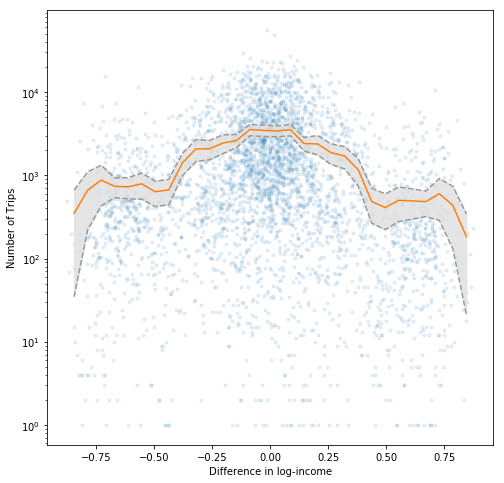

In [32]:
plt.figure(figsize=(8, 8))
plot_binned(
    df_pairs_nyc['log_income_diff'], df_pairs_nyc['trips'],
    log='y', alpha=0.8,
    xlabel='Difference in log-income',
    ylabel='Number of Trips')

#### Trip Distance and Connectivity

(0.9, 50000)

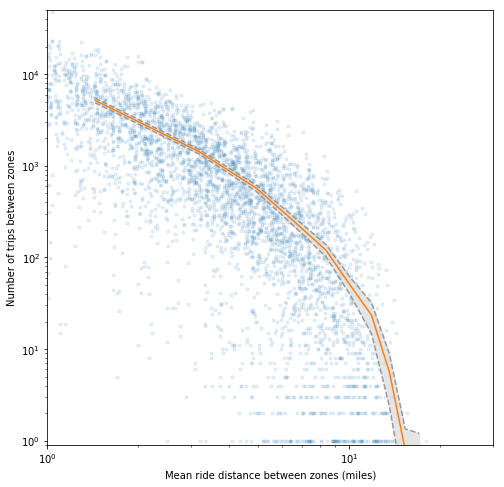

In [33]:
# Calculate trip distance vs income difference
plt.figure(figsize=(8, 8))
plot_binned(
    df_pairs_nyc['trip_distance'], df_pairs_nyc['trips'],
    log='xy', alpha=0.8, bins=10,
    xlabel='Mean ride distance between zones (miles)',
    ylabel='Number of trips between zones')
plt.xlim([1, 30])
plt.ylim([0.9, 50000])

#### Fixing Distance

In [34]:
# Helper functions

def filter_zones(df_pairs, distance, tolerance):
    df = df_pairs[(df_pairs.trip_distance - distance).abs() < tolerance]
    return df

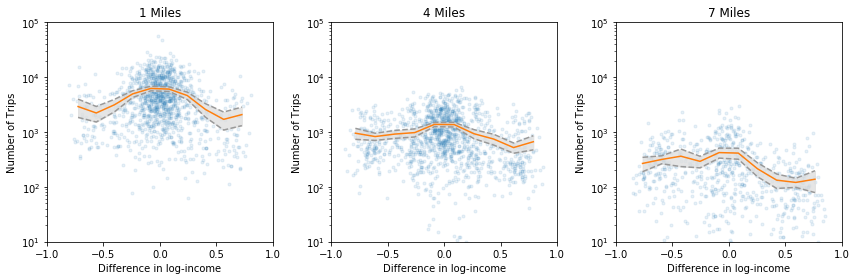

In [35]:
plt.figure(figsize=(12, 4))
for i, miles in enumerate([1, 4, 7]):
    df_pairs_miles = filter_zones(df_pairs_nyc, miles, 1.5)
    plt.subplot(1, 3, i + 1)
    plot_binned(
        df_pairs_miles['log_income_diff'],
        df_pairs_miles['trips'],
        bins=10, log='y', alpha=0.8,
        xlabel='Difference in log-income',
        ylabel='Number of Trips',
        title='{} Miles'.format(miles))
    plt.ylim([10, 100000])
    plt.xlim([-1, 1])
plt.tight_layout()

#### Selecting based on time

In [36]:
# Helper functions

def get_trip_datetime(df):
    print('Finding trip times')
    weekday = []
    hour = []
    minute = []
    
    for i in tqdm(df.index):
        s = df.loc[i, 'tpep_pickup_datetime']
        dt = datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
        weekday.append(dt.weekday())
        hour.append(dt.hour)
        minute.append(dt.minute)
    
    df['weekday'] = weekday
    df['hour'] = hour
    df['minute'] = minute

def get_time_pairs(df, taxi_geo, zone_incomes):
    time_periods = {
        'AM Rush': [(5, 10)],
        'Midday': [(10, 16)],
        'PM Rush': [(16, 20)],
        'Night': [(0, 5), (20, 24)]
    }
    pairs = {}
    for label, periods in time_periods.items():
        selection = pd.Series(False, index=df.index)
        # Check hour of day
        for start, stop in periods:
            selection = selection | (
                (df.hour >= start)
                & (df.hour < stop))
            print(len(df[selection]))
        # M-F only
        selection = selection & (df.weekday < 5)
        # Select data
        df_period = df[selection]
        pairs[label] = make_pair_df(taxi_geo)
        count_trips(df_period, pairs[label])
        get_mean_distance(df_period, pairs[label])
        get_log_diff(pairs[label], 'income', zone_incomes, min_value=12300)
    return pairs

In [37]:
df = pd.DataFrame(df_taxi[~df_taxi.index.duplicated(keep='first')])
get_trip_datetime(df)

  0%|          | 0/9710124 [00:00<?, ?it/s]

Finding trip times


100%|██████████| 9710124/9710124 [06:30<00:00, 24840.18it/s]


In [38]:
time_pairs = get_time_pairs(df, taxi_geo, zone_incomes)

1599696
Counting trips


100%|██████████| 65792/65792 [00:29<00:00, 2219.51it/s]


Finding mean distance


  1%|          | 481/65792 [00:00<00:13, 4804.03it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4964.50it/s]


2931282
Counting trips


100%|██████████| 65792/65792 [00:30<00:00, 2180.71it/s]


Finding mean distance


  1%|          | 476/65792 [00:00<00:13, 4755.66it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4950.04it/s]


2235565
Counting trips


100%|██████████| 65792/65792 [00:30<00:00, 2159.40it/s]


Finding mean distance


  1%|          | 495/65792 [00:00<00:13, 4944.56it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4934.60it/s]


990309
2943581
Counting trips


100%|██████████| 65792/65792 [00:28<00:00, 2317.95it/s]


Finding mean distance


  1%|          | 485/65792 [00:00<00:13, 4848.73it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4906.12it/s]


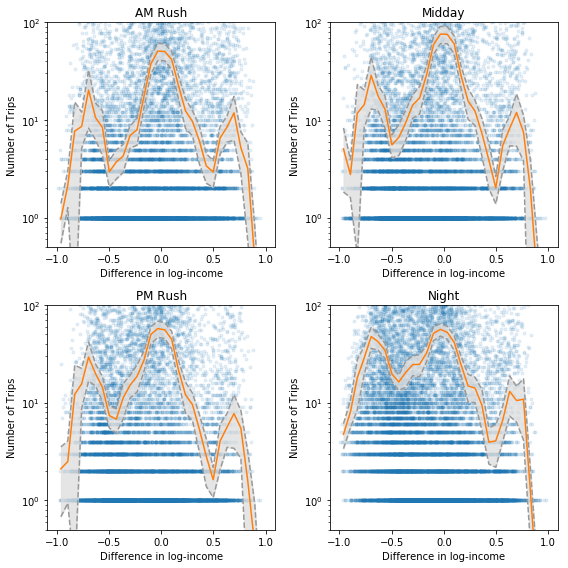

In [39]:
plt.figure(figsize=(8, 8))
for i, (label, pairs) in enumerate(time_pairs.items()):
    plt.subplot(2,2,1 + i)
    plot_binned(
        pairs['log_income_diff'], pairs['trips'],
        log='y', alpha=0.8,
        xlabel='Difference in log-income',
        ylabel='Number of Trips',
        title=label)
    plt.ylim([0.5, 100])
plt.tight_layout()

In [40]:
df_weekend = df[df.weekday >= 5]
df_pairs_weekend = make_pair_df(taxi_geo)
count_trips(df_weekend, df_pairs_weekend)
get_mean_distance(df_weekend, df_pairs_weekend)
get_log_diff(df_pairs_weekend, 'income', zone_incomes, min_value=12300)


Counting trips


100%|██████████| 65792/65792 [00:27<00:00, 2369.80it/s]


Finding mean distance


  1%|          | 469/65792 [00:00<00:13, 4686.38it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:13<00:00, 4953.40it/s]


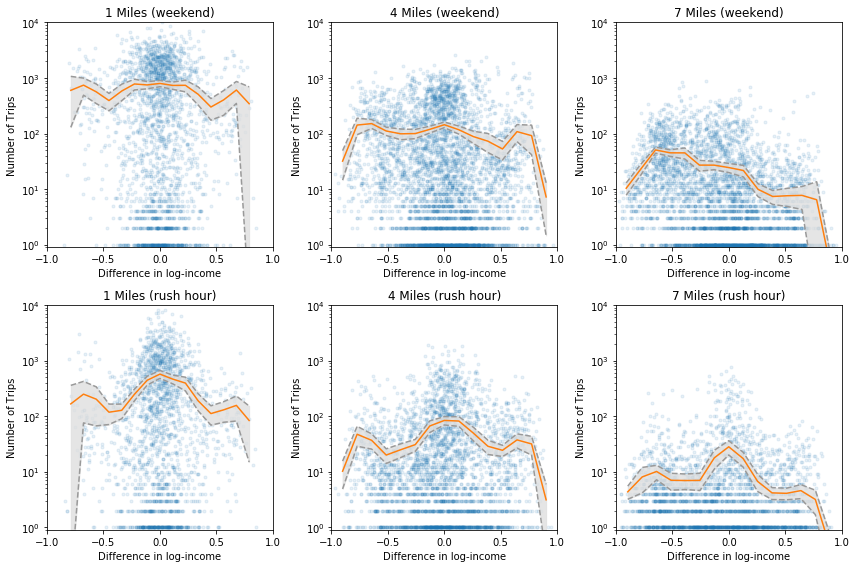

In [41]:
plt.figure(figsize=(12, 8))
for i, miles in enumerate([1, 4, 7]):
    df_pairs_miles = filter_zones(df_pairs_weekend, miles, 1.5)
    plt.subplot(2, 3, i + 1)
    plot_binned(
        df_pairs_miles['log_income_diff'],
        df_pairs_miles['trips'],
        bins=15, log='y', alpha=0.8,
        xlabel='Difference in log-income',
        ylabel='Number of Trips',
        title='{} Miles (weekend)'.format(miles))
    plt.ylim([0.9, 10000])
    plt.xlim([-1, 1])
for i, miles in enumerate([1, 4, 7]):
    df_pairs_miles = filter_zones(time_pairs['AM Rush'], miles, 1.5)
    plt.subplot(2, 3, i + 4)
    plot_binned(
        df_pairs_miles['log_income_diff'],
        df_pairs_miles['trips'],
        bins=15, log='y', alpha=0.8,
        xlabel='Difference in log-income',
        ylabel='Number of Trips',
        title='{} Miles (rush hour)'.format(miles))
    plt.ylim([0.9, 10000])
    plt.xlim([-1, 1])
plt.tight_layout()


#### Examining individual pairs

In [42]:
# Helper functions

def print_zone(geo, location_id):
    for r in geo:
        if r.attributes['LocationID'] == location_id:
            print('{}: {}'.format(
                r.attributes['borough'],
                r.attributes['zone']))
            print('Median income:', r.attributes['income'])
            break
            
def trip_weekday_hist(df, geo, source, dest, ymax):
    r_source = taxi_geo_dict[source]
    r_dest = taxi_geo_dict[dest]
    bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    df[(df.PULocationID == source) & (df.DOLocationID == dest)]['weekday'].hist(bins=bins)
    plt.ylim([0, ymax])
    plt.title('{} \n-> {}'.format(
        r_source.attributes['zone'],
        r_dest.attributes['zone']))
    plt.xticks(
        range(7),
        ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su'])
    plt.xlim([-0.5,6.5])

def trip_time_hist(df, geo, source, dest, ymax):
    r_source = taxi_geo_dict[source]
    r_dest = taxi_geo_dict[dest]
    df[(df.PULocationID == source) & (df.DOLocationID == dest)]['hour'].hist(bins=24)
    plt.ylim([0, ymax])
    plt.title('{} \n-> {}'.format(
        r_source.attributes['zone'],
        r_dest.attributes['zone']))

In [43]:
taxi_geo_dict = {}
for r in taxi_geo:
    taxi_geo_dict[r.attributes['LocationID']] = r

In [44]:
sel = (((time_pairs['AM Rush'].log_income_diff - 0.75).abs() < 0.05)
       & (time_pairs['AM Rush'].trip_distance > 2))

time_pairs['AM Rush'][sel].sort_values('trips', ascending=False).head()


,trips,trip_distance,log_income_diff
"(148, 162)",260.0,3.196332,0.726210
"(75, 142)",246.0,2.774763,0.741603
"(74, 140)",196.0,2.919794,0.702358
"(74, 141)",137.0,2.708336,0.765867
"(75, 229)",127.0,2.839733,0.714497


In [45]:
print_zone(taxi_geo, 148)

Manhattan: Lower East Side
Median income: 41621.494277531965


In [46]:
print_zone(taxi_geo, 162)

Manhattan: Midtown East
Median income: 221578.31530840954


In [47]:
sel = (((time_pairs['AM Rush'].log_income_diff + 0.75).abs() < 0.05)
       & (time_pairs['AM Rush'].trip_distance > 2))

time_pairs['AM Rush'][sel].sort_values('trips', ascending=False).head()

,trips,trip_distance,log_income_diff
"(262, 74)",691.0,2.239269,-0.710776
"(141, 74)",428.0,2.708336,-0.765867
"(142, 75)",344.0,2.774763,-0.741603
"(140, 74)",338.0,2.919794,-0.702358
"(229, 75)",285.0,2.839733,-0.714497


In [48]:
print_zone(taxi_geo, 229)

Manhattan: Sutton Place/Turtle Bay North
Median income: 233626.6556472157


In [49]:
print_zone(taxi_geo, 75)

Manhattan: East Harlem South
Median income: 45084.33293351601


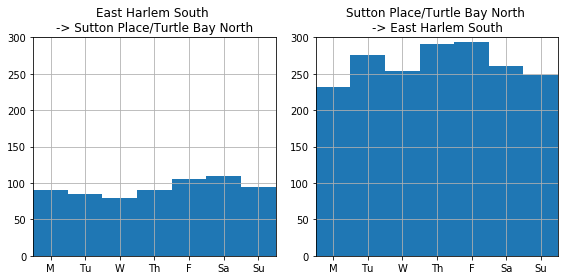

In [50]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
trip_weekday_hist(df, taxi_geo, source=75, dest=229, ymax=300)    
plt.subplot(1,2,2)
trip_weekday_hist(df, taxi_geo, source=229, dest=75, ymax=300)    
plt.tight_layout()

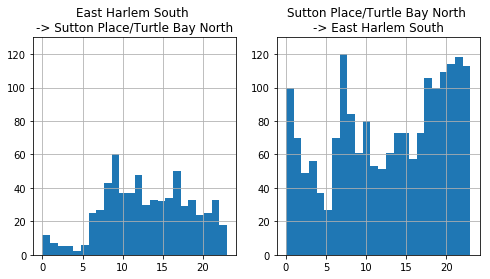

In [51]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
trip_time_hist(df, taxi_geo, source=75, dest=229, ymax=130)
plt.subplot(1,2,2)
trip_time_hist(df, taxi_geo, source=229, dest=75, ymax=130)


Thinking about fragmentary nature of data

#### Net Flow

#### Try It Yourself: Race

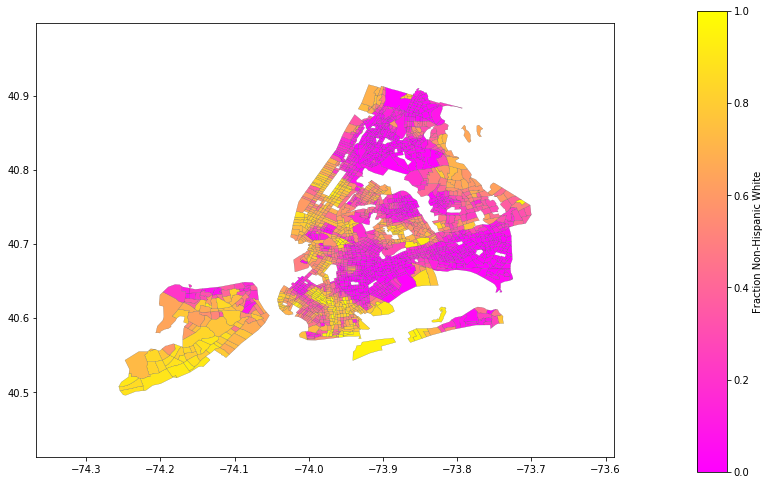

In [52]:
tract_race_map = get_geo_map(df_census, 'non_hispanic_white_frac', tract_geo)
annotate_records(tract_geo, tract_race_map, 'non_hispanic_white_frac')
plot_geo_values(tract_geo, 'non_hispanic_white_frac', cmap='spring', label="Fraction Non-Hispanic White")


100%|██████████| 257/257 [00:13<00:00, 19.07it/s]


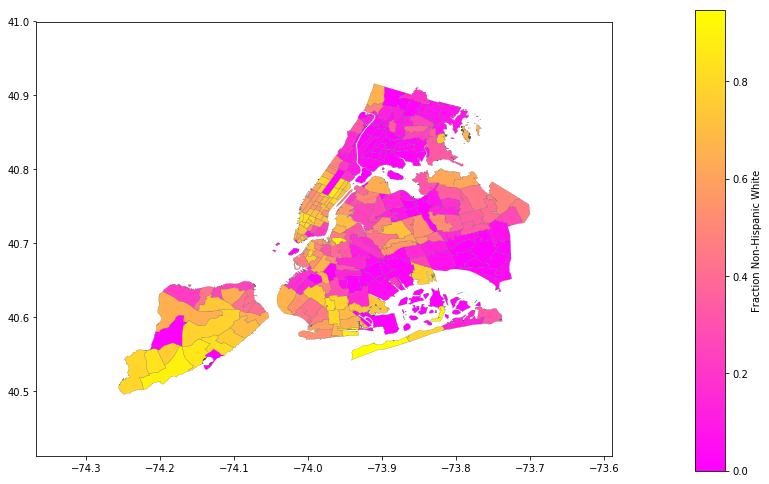

In [53]:
zone_race = tract_to_zone(df_census['non_hispanic_white_frac'])
for zone in taxi_geo: 
    zone_id = zone.attributes['LocationID']
    zone.attributes['non_hispanic_white_frac'] = zone_race[zone_id]
plot_geo_values(taxi_geo, 'non_hispanic_white_frac', label="Fraction Non-Hispanic White", cmap='spring')

In [54]:
get_diff(df_pairs, 'non_hispanic_white_frac', zone_race)

  1%|          | 480/65792 [00:00<00:13, 4796.31it/s]

Finding attribute difference


100%|██████████| 65792/65792 [00:12<00:00, 5230.28it/s]


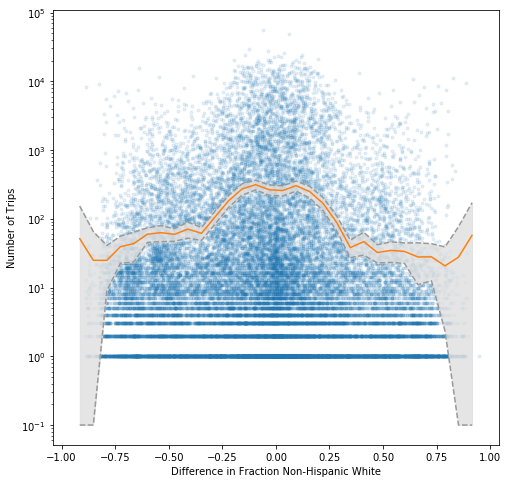

In [55]:
plt.figure(figsize=(8, 8))
plot_binned(
    df_pairs['non_hispanic_white_frac_diff'], df_pairs['trips'],
    log='y', alpha=0.8,
    xlabel='Difference in Fraction Non-Hispanic White',
    ylabel='Number of Trips')

#### Reflection Questions

Visualizing income vs racial segregation

Differentiate between distance and other factors

Asymmetries and incompleteness in the data

Time, consider differences between citiess